# Finished product of the Micrograd

**The 20th Summer Project**

**Coded and Created by Han summer 2024**

Based on Karpathy's Micrograd library

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Replace = to += in the backward pass
#Remember the += is will accumulate the contribution from all paths and not overide it (Multivariable chainrule)
class Value:
    def __init__(self, data,_children=(), _op='', label=''): #Inisiasi value object, data value, _children awalnya empty, _op awalnya empty, add labels to the visualized graph
        self.data=data
        self._backward= lambda: None #Backward pass, by default fungsi yang tidak ada apa apa (none)
        self.grad=0.0 #Gradient, awalnya 0 (means no effect), we assume each initial value has no effect to the final value
        self._prev=set(_children) #Set of children, we need to keep track of what values produce other value (Connected)
        self._op=_op #Operation (String), to keep track of what operation was used to produce this value
        self.label=label #Label 
        
    def __repr__(self): #Representasi (Repr) value object, it's providing nice looking print of the value, not some random address
        return f'Value(data={self.data})'
    
    #Awalnya kalau ada 2 object value, misal a dan b, a+b bakal error karena tidak ada method __add__ yang mendefinisikan operasi penjumlahan
    def __add__(self, other):
        out= Value(self.data+other.data,(self,other),'+') #This is typical addition not __add__ method
        #Value(self, data= data hasil perhitungan, children= angka yang dihitung/inputnya, _op= operasi yang dilakukan)
        def _backward(): #Take out.grad and propagrate it to self.grad and other.grad
            #Dalam penjumlahan kan gradientnya akan sama di 2 node yang dijumlahkan, jadi ya copy aja
            self.grad+= 1.0*out.grad 
            other.grad+= 1.0*out.grad
        out._backward= _backward #save the backward pass function to the object, jadi berdasarkan operasi, fungsi backward passnya bakal beda beda
        return out
    
    #Multiply
    def __mul__(self, other):
        out= Value(self.data*other.data,(self,other),'*')
        
        def _backward():#Take out.grad and propagrate it to self.grad and other.grad
            #Kalo multiply jadi chain rule
            self.grad+= other.data*out.grad
            other.grad+= self.data*out.grad
        out._backward= _backward #save the backward pass function to the object, jadi berdasarkan operasi, fungsi backward passnya bakal beda beda
            
        return out
    #Tanh activation function , butuh huruf e (2.71828)
    def tanh(self):
        x=self.data #Value of the object
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out= Value(t,(self,), 'tanh')
        
        def _backward():
            self.grad+= (1-t**2)*out.grad #Local derivative of tanh * gradient of the output
        out._backward= _backward #save the backward pass function to the object, jadi berdasarkan operasi, fungsi backward passnya bakal beda beda
        return out
    
    #Topological sort + backward function call
    def backward(self):
        #Build the topological sort first
        topo = []
        visited = set()
        def build_topo(v): 
            if v not in visited: #Keep track of visited note, put the node in visited
                visited.add(v)
            for child in v._prev: #After that go through the children first
                build_topo(child) #Call the function again with the children as output
            topo.append(v) #After the child has been added or there is no child left, next add itself to the topo list
        build_topo(self) #start from the self node (should be the last leaf node or output)

        # And then, Backward pass
        #First initialize the basecase (output(self) gradient), this backward() function should be called in output node object (o)
        self.grad=1.0 
        # kita balik topologicalnya, jadi call function backwardnya berurutan dari output ke node input
        for node in reversed(topo):
            node._backward() #Call the backward pass function for each node in the topological sort

In [6]:
from graphviz import Digraph
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [7]:
#Lets redefine the graph and do the backward pass
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o=n.tanh() ; o.label='o'
o.backward()
o

Value(data=0.7071067811865476)

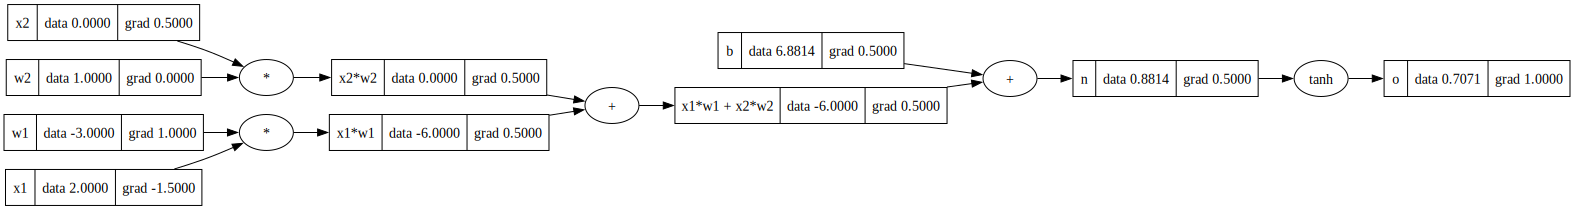

In [8]:
draw_dot(o)

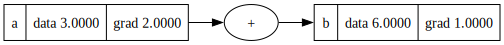

In [9]:
a=Value(3.0,label='a')
b=a+a ; b.label='b'
b.backward()
draw_dot(b)

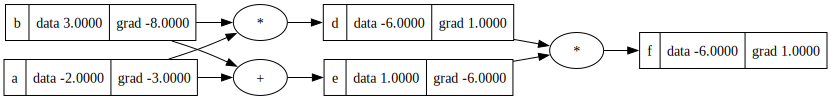

In [13]:
# Contoh lain
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)